<a href="https://colab.research.google.com/github/ZaichenkoNA/Stat_Prac/blob/main/Proekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
credits_df = pd.read_csv("./drive/MyDrive/credits.csv", low_memory=False)
titles_df = pd.read_csv("./drive/MyDrive/titles.csv", low_memory=False)

print(credits_df.head())
print(titles_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   person_id       id             name                character   role
0       3748  tm84618   Robert De Niro            Travis Bickle  ACTOR
1      14658  tm84618     Jodie Foster            Iris Steensma  ACTOR
2       7064  tm84618    Albert Brooks                      Tom  ACTOR
3       3739  tm84618    Harvey Keitel  Matthew 'Sport' Higgins  ACTOR
4      48933  tm84618  Cybill Shepherd                    Betsy  ACTOR
         id                                title   type  \
0  ts300399  Five Came Back: The Reference Films   SHOW   
1   tm84618                          Taxi Driver  MOVIE   
2  tm154986                          Deliverance  MOVIE   
3  tm127384      Monty Python and the Holy Grail  MOVIE   
4  tm120801                      The Dirty Dozen  MOVIE   

                                         description  release_year  \
0  This collection i

In [18]:
print(credits_df.info())
print(titles_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77801 entries, 0 to 77800
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   person_id  77801 non-null  int64 
 1   id         77801 non-null  object
 2   name       77801 non-null  object
 3   character  68029 non-null  object
 4   role       77801 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64 

In [19]:

print(titles_df.describe())

       release_year      runtime      seasons   imdb_score    imdb_votes  \
count   5850.000000  5850.000000  2106.000000  5368.000000  5.352000e+03   
mean    2016.417094    76.888889     2.162868     6.510861  2.343938e+04   
std        6.937726    39.002509     2.689041     1.163826  9.582047e+04   
min     1945.000000     0.000000     1.000000     1.500000  5.000000e+00   
25%     2016.000000    44.000000     1.000000     5.800000  5.167500e+02   
50%     2018.000000    83.000000     1.000000     6.600000  2.233500e+03   
75%     2020.000000   104.000000     2.000000     7.300000  9.494000e+03   
max     2022.000000   240.000000    42.000000     9.600000  2.294231e+06   

       tmdb_popularity   tmdb_score  
count      5759.000000  5539.000000  
mean         22.637925     6.829175  
std          81.680263     1.170391  
min           0.009442     0.500000  
25%           2.728500     6.100000  
50%           6.821000     6.900000  
75%          16.590000     7.537500  
max        

Проверим отсутствующие данные:

In [20]:
credits_df.isna().sum()


,0
person_id,0
id,0
name,0
character,9772
role,0


In [21]:
titles_df.isna().sum()

,0
id,0
title,1
type,0
description,18
release_year,0
age_certification,2619
runtime,0
genres,0
production_countries,0
seasons,3744


Обработка данных:

In [22]:
import numpy as np

# Подсчет популярности актеров
actor_counts = credits_df["name"].value_counts()
credits_df["actor_popularity"] = credits_df["name"].map(actor_counts)

# Фичи по актерам
actor_popularity_per_movie = credits_df.groupby("id")["actor_popularity"].mean().reset_index()
actor_popularity_per_movie.rename(columns={"actor_popularity": "avg_actor_popularity"}, inplace=True)

actor_count_per_movie = credits_df.groupby("id")["person_id"].count().reset_index()
actor_count_per_movie.rename(columns={"person_id": "num_actors"}, inplace=True)

top_100_actors = set(actor_counts.head(100).index)
credits_df["has_top_actor"] = credits_df["name"].isin(top_100_actors)
top_actor_flag_per_movie = credits_df.groupby("id")["has_top_actor"].max().reset_index()

# Объединяем с основной таблицей
titles_df = titles_df.merge(actor_popularity_per_movie, on="id", how="left")
titles_df = titles_df.merge(actor_count_per_movie, on="id", how="left")
titles_df = titles_df.merge(top_actor_flag_per_movie, on="id", how="left")

# Заполнение пропусков (присваиваем результат обратно в столбцы)
titles_df["avg_actor_popularity"] = titles_df["avg_actor_popularity"].fillna(0)
titles_df["num_actors"] = titles_df["num_actors"].fillna(0)
titles_df["has_top_actor"] = titles_df["has_top_actor"].fillna(False)
titles_df["runtime"] = titles_df["runtime"].fillna(titles_df["runtime"].median())
titles_df["tmdb_popularity"] = titles_df["tmdb_popularity"].fillna(0)
titles_df["imdb_votes"] = titles_df["imdb_votes"].fillna(0)

# Обработка жанров (one-hot encoding)
genres_exploded = titles_df["genres"].str.strip("[]").str.replace("'", "").str.split(", ")
unique_genres = set([g for sublist in genres_exploded.dropna() for g in sublist])

# Формируем DataFrame с бинарными признаками для каждого жанра
genre_df = pd.DataFrame({
    f"genre_{genre}": genres_exploded.apply(lambda x: genre in x if isinstance(x, list) else False)
    for genre in unique_genres
})
titles_df = pd.concat([titles_df, genre_df], axis=1)

# Обработка стран (one-hot encoding)
countries_exploded = titles_df["production_countries"].str.strip("[]").str.replace("'", "").str.split(", ")
unique_countries = set([c for sublist in countries_exploded.dropna() for c in sublist])
country_df = pd.DataFrame({
    f"country_{country}": countries_exploded.apply(lambda x: country in x if isinstance(x, list) else False)
    for country in unique_countries
})
titles_df = pd.concat([titles_df, country_df], axis=1)

titles_df = titles_df.dropna(subset=["imdb_score"])
print("Предобработка завершена!")


<ipython-input-22-4e273931e60c>:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titles_df["has_top_actor"] = titles_df["has_top_actor"].fillna(False)


Предобработка завершена!


Найдём распределения:

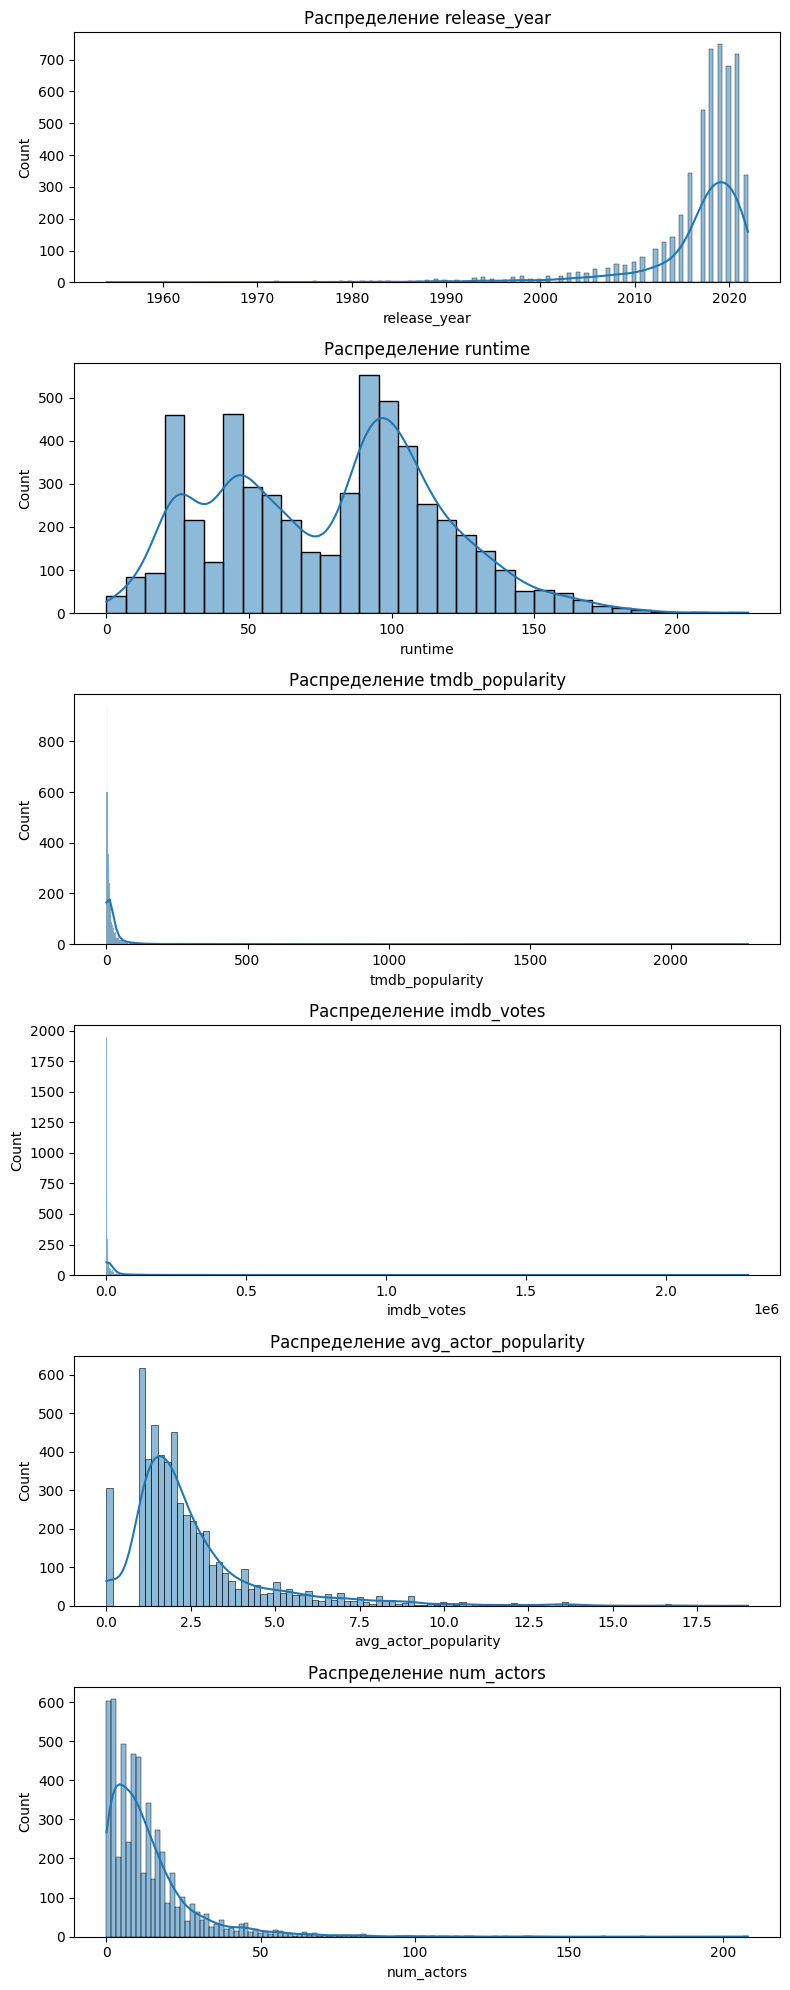

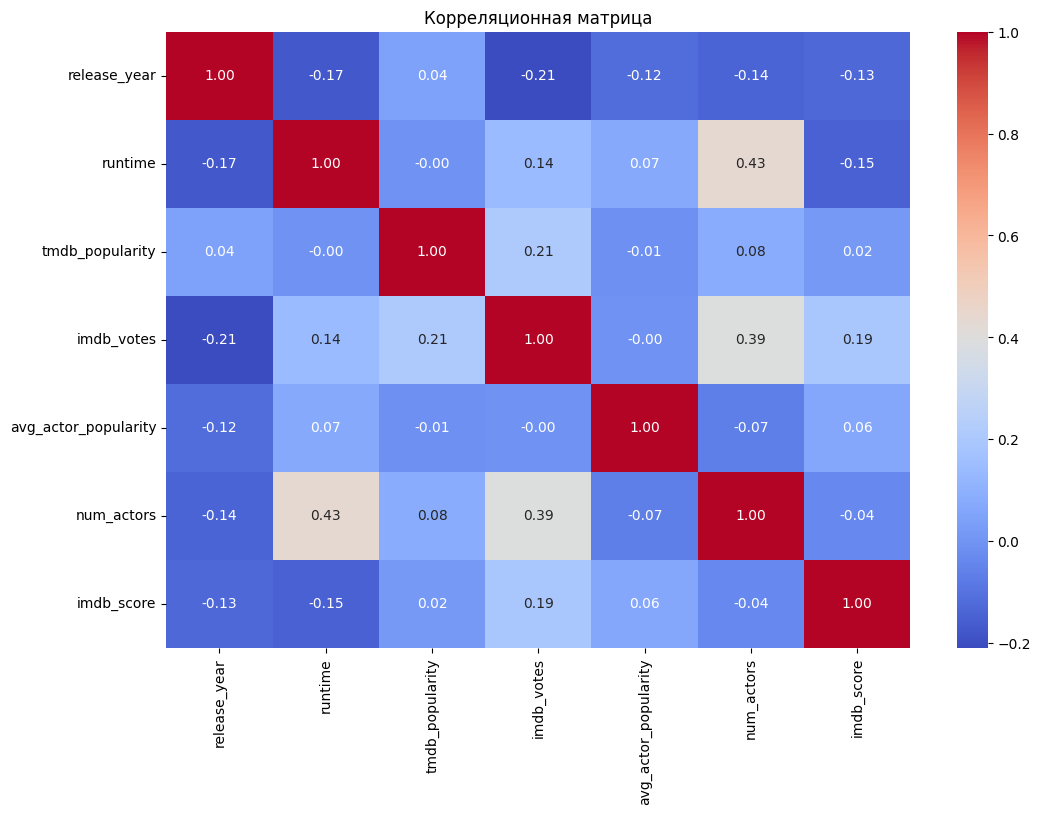

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Числовые признаки
numeric_features = ["release_year", "runtime", "tmdb_popularity", "imdb_votes", "avg_actor_popularity", "num_actors"]

# Гистограммы
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(8, 20))
for i, feature in enumerate(numeric_features):
    sns.histplot(titles_df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f"Распределение {feature}")
plt.tight_layout()
plt.show()

# Корреляционная матрица
corr_matrix = titles_df[numeric_features + ["imdb_score"]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

Графики для распределений tmdb_popularity и imdb_votes выглядят не очень читаемыми. Давайте ограничим ось х, чтобы увидеть, что происходит с количеством фильмов ближе к 0 по оси х:

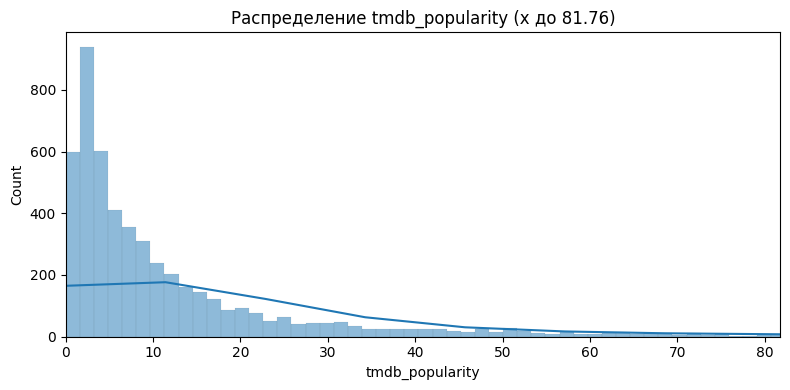

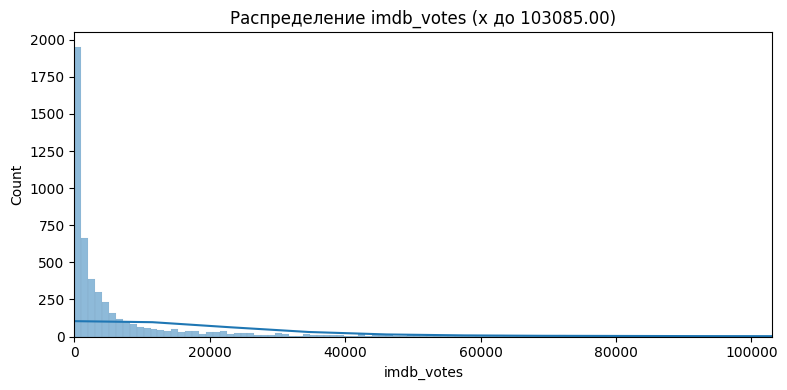

In [24]:
def plot_limited_hist(feature, quantile=0.95):
    plt.figure(figsize=(8, 4))
    ax = sns.histplot(titles_df[feature], kde=True)
    upper_lim = titles_df[feature].quantile(quantile)
    ax.set_xlim(0, upper_lim)
    ax.set_title(f"Распределение {feature} (x до {upper_lim:.2f})")
    ax.set_xlabel(feature)
    plt.tight_layout()
    plt.show()

# Построение гистограмм для tmdb_popularity и imdb_votes с ограничением оси x
plot_limited_hist("tmdb_popularity", quantile=0.95)
plot_limited_hist("imdb_votes", quantile=0.95)

Посмотрим на рейтинг по странам:

<ipython-input-42-97df44aca064>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


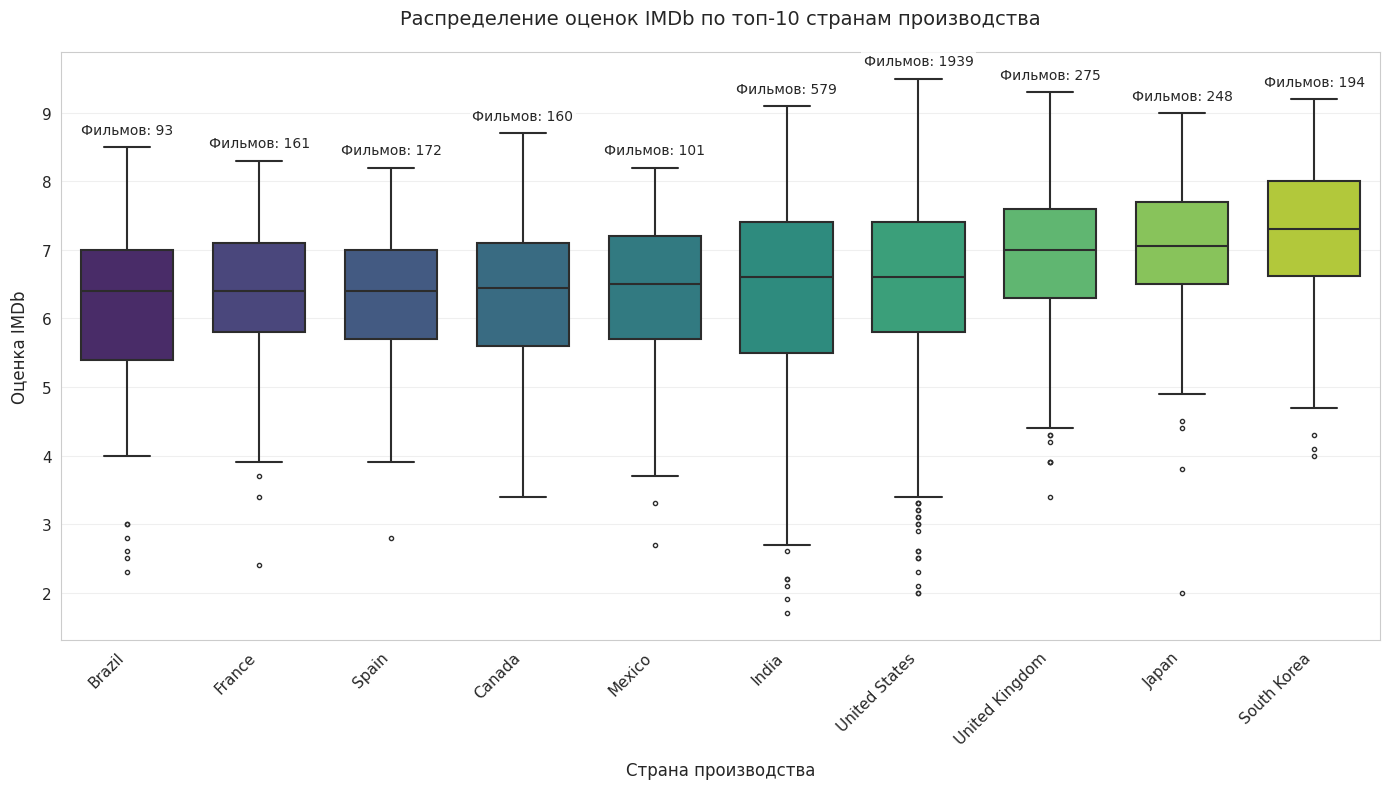

In [42]:
import pycountry

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Функция для преобразования кодов стран в полные названия
def extract_and_convert_country(raw_str):
    if not isinstance(raw_str, str):  # Проверяем, что это строка
        return None
    cleaned = raw_str.strip("[]").replace("'", "").replace("\"", "").strip()
    if not cleaned:
        return None
    codes = [code.strip() for code in cleaned.split(",") if code.strip()]
    if not codes:
        return None
    code = codes[0]
    country = pycountry.countries.get(alpha_2=code.upper())
    return country.name if country else None

titles_df["production_countries_full"] = titles_df["production_countries"].apply(extract_and_convert_country)

valid_titles = titles_df[titles_df["production_countries_full"].notnull()]
filtered_titles = valid_titles.copy()
# Заменяем название Южной Кореи на более короткое
filtered_titles["production_countries_full"] = filtered_titles["production_countries_full"].replace(
    "Korea, Republic of", "South Korea")

# Выбираем топ-10 стран по количеству фильмов
top_countries = filtered_titles["production_countries_full"].value_counts().head(10).index
filtered_df = filtered_titles[filtered_titles["production_countries_full"].isin(top_countries)]

# Сортируем страны по медианному значению IMDb
country_order = filtered_df.groupby("production_countries_full")["imdb_score"].median().sort_values().index

plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    x="production_countries_full",
    y="imdb_score",
    data=filtered_df,
    order=country_order,
    palette="viridis",
    width=0.7,
    linewidth=1.5,
    fliersize=3
)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Страна производства", fontsize=12, labelpad=10)
plt.ylabel("Оценка IMDb", fontsize=12, labelpad=10)
plt.title("Распределение оценок IMDb по топ-10 странам производства", fontsize=14, pad=20)

# Добавляем аннотации с количеством фильмов
counts = filtered_df["production_countries_full"].value_counts().loc[country_order]
max_scores = filtered_df.groupby("production_countries_full")["imdb_score"].max().loc[country_order]

for i, country in enumerate(country_order):
    count = counts[country]
    y_pos = max_scores[country] + 0.15
    ax.text(
        i, y_pos, f"Фильмов: {count}",
        ha='center',
        va='bottom',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

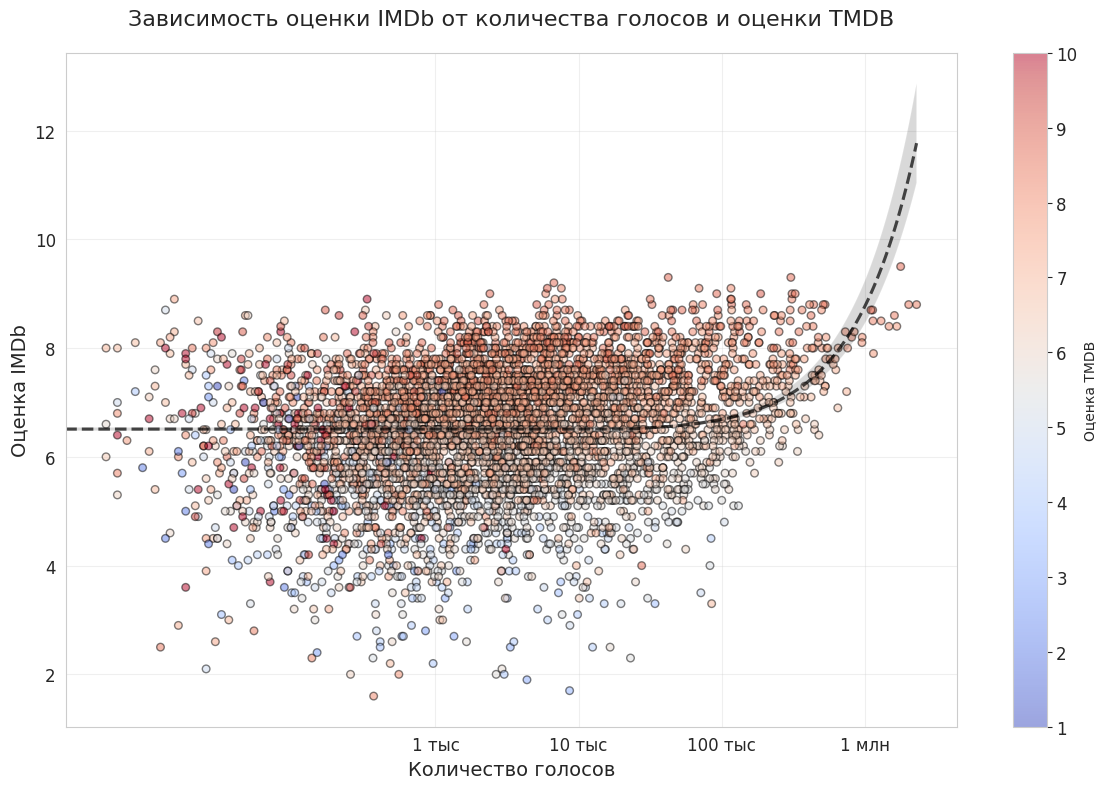

In [45]:
plt.figure(figsize=(12, 8))

plt.scatter(titles_df["imdb_votes"], titles_df["imdb_score"],
            c=titles_df["tmdb_score"],
            edgecolors='k',
            alpha=0.5,
            s=30,
            cmap="coolwarm")

# Добавляем сглаживающую линию (регрессию)
sns.regplot(x="imdb_votes", y="imdb_score",
            data=titles_df,
            scatter=False,
            color='black',
            line_kws={'linestyle':'--', 'alpha':0.7})

plt.grid(True, alpha=0.3)
cbar = plt.colorbar(label="Оценка TMDB")
cbar.ax.tick_params(labelsize=12)

plt.title("Зависимость оценки IMDb от количества голосов и оценки TMDB", fontsize=16, pad=20)
plt.xlabel("Количество голосов", fontsize=14)
plt.ylabel("Оценка IMDb", fontsize=14)
plt.xscale("log")

plt.xticks([1e3, 1e4, 1e5, 1e6],
           ['1 тыс', '10 тыс', '100 тыс', '1 млн'],
           fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

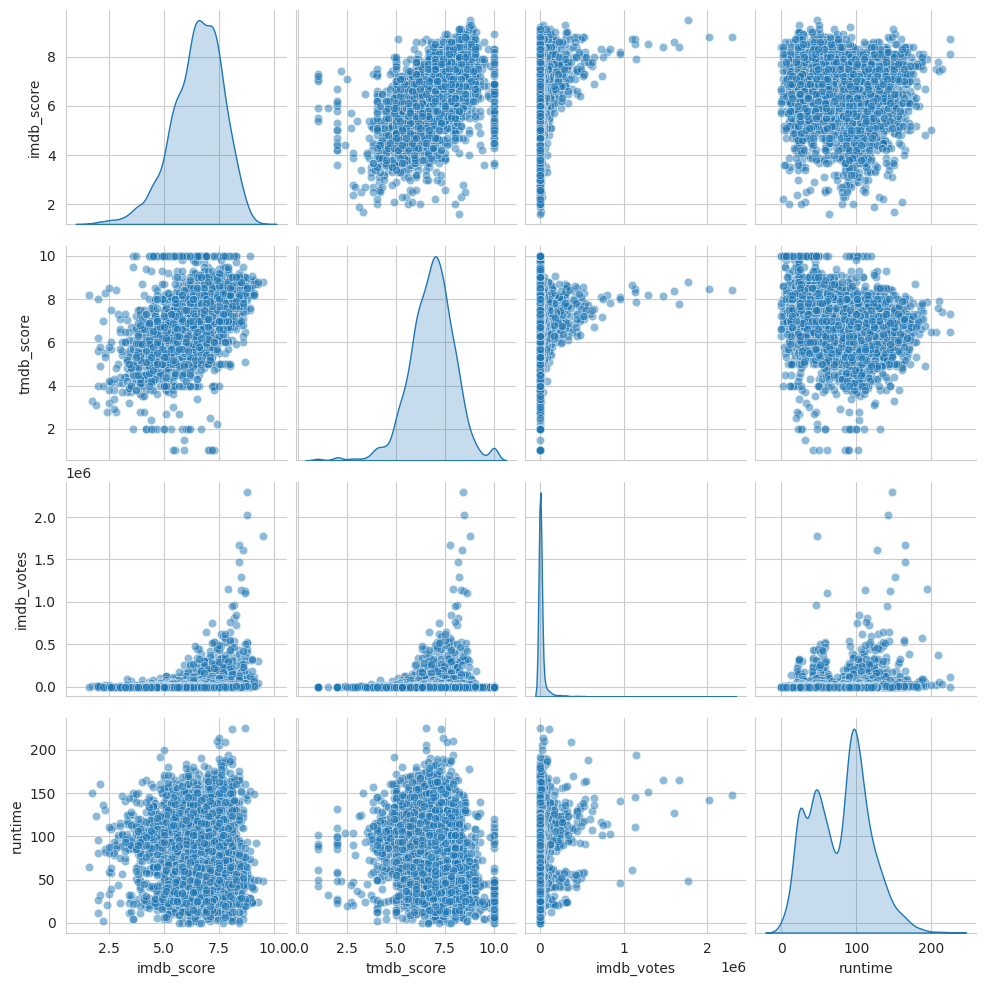

In [46]:
import seaborn as sns

# Выбираем нужные числовые колонки
selected_columns = ["imdb_score", "tmdb_score", "imdb_votes", "runtime"]
pairplot_df = titles_df[selected_columns].dropna()

# Строим pairplot
sns.pairplot(pairplot_df, diag_kind="kde", plot_kws={'alpha': 0.5})

plt.show()